In [401]:
import requests
import json
import datetime
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
sns.set(rc={'figure.figsize':(17,8.27)})
pd.options.display.float_format = '{:.2f}'.format
import ta
import warnings
warnings.filterwarnings('ignore')
#from ETH_parser import get_floor_price, get_sales_collection, get_sales_token, get_attributes, get_attributes_collection, get_rarity, get_block_timestamp

In [27]:
API_KEY = "vYHU2nVXBMrIHlByeFOQWubnRQcl_v_3"
BAYC = "0xbc4ca0eda7647a8ab7c2061c2e118a18a936f13d"
AZUKI = "0xed5af388653567af2f388e6224dc7c4b3241c544"

In [3]:
def get_floor_price(API: str, address: str) -> dict:
    url = f"https://eth-mainnet.g.alchemy.com/nft/v2/{API}/getFloorPrice?contractAddress={address}"
    headers = {"accept": "application/json"}
    response = requests.get(url, headers=headers)
    data = json.loads(response.text)
    
    prices = {"opensea": data['openSea']['floorPrice'],
              "looksrare": data['looksRare']['floorPrice']}

    return prices

In [4]:
# OLD
# def get_sales_collection(API: str, address: str, limit: int) -> json:
#     url = f"https://eth-mainnet.g.alchemy.com/nft/v3/{API}/getNFTSales?fromBlock=0&toBlock=latest&order=desc&marketplace=seaport&contractAddress={address}&limit={limit}"
#     headers = {"accept": "application/json"}
#     response = requests.get(url, headers=headers)
#     data = json.loads(response.text)

    
#     activity = [{"tokenId": sale["tokenId"],
#                  "marketplace": sale["marketplace"],
#                  "block": sale["blockNumber"],
#                  "token": sale["sellerFee"]["symbol"],
#                  "price": 0 if sale["sellerFee"]["amount"] is None else int(sale["sellerFee"]["amount"]) / 10 ** 18} for sale in data["nftSales"]]

#     return activity

In [59]:
def get_sales_collection(API: str, address: str, to_block, limit: int):
    url = f"https://eth-mainnet.g.alchemy.com/nft/v3/{API}/getNFTSales?fromBlock=0&toBlock={to_block}&order=desc&contractAddress={address}&limit={limit}"
    headers = {"accept": "application/json"}
    response = requests.get(url, headers=headers)
    data = json.loads(response.text)

    activity = [{"tokenId": sale["tokenId"],
                 "marketplace": sale["marketplace"],
                 "block": sale["blockNumber"],
                 "token": sale["sellerFee"]["symbol"],
                 "price": 0 if sale["sellerFee"]["amount"] is None else int(sale["sellerFee"]["amount"]) / 10 ** 18} for sale in data["nftSales"]]

    return pd.DataFrame(activity)

In [6]:
def get_sales_token(API: str, address: str, limit: int, tokenId: int) -> json:
    url = f"https://eth-mainnet.g.alchemy.com/nft/v2/{API}/getNFTSales?fromBlock=0&toBlock=latest&order=desc&contractAddress={address}&limit={limit}&tokenId={tokenId}"
    headers = {"accept": "application/json"}
    response = requests.get(url, headers=headers)
    data = json.loads(response.text)
    
    activity = [{"tokenId": sale["tokenId"],
                 "marketplace": sale["marketplace"],
                 "sellerFee": int(sale["sellerFee"]["amount"]) / 10 ** 18} for sale in data["nftSales"]]
    
    return activity

In [7]:
def get_attributes(API: str, address: str, tokenId: int) -> json:
    url = f"https://eth-mainnet.g.alchemy.com/nft/v2/{API}/computeRarity?contractAddress={address}&tokenId={tokenId}"
    headers = {"accept": "application/json"}
    response = requests.get(url, headers=headers)
    data = json.loads(response.text)

    return data

In [8]:
def get_attributes_collection(API: str, address: str) -> json:
    url = f"https://eth-mainnet.g.alchemy.com/nft/v2/{API}/summarizeNFTAttributes?contractAddress={address}"
    headers = {"accept": "application/json"}
    response = requests.get(url, headers=headers)
    data = json.loads(response.text)
    
    return data['summary']

In [9]:
def get_rarity(API: str, address: str, tokenId: int) -> json:
    data = get_attributes(API=API, address=address, tokenId=tokenId)
    
    result = 1
    for rarity in data:
        result *= rarity["prevalence"]
        
    return result

In [10]:
def get_block_timestamp(block_number):
    url = f"https://eth-mainnet.alchemyapi.io/v2/{API_KEY}"
    payload = json.dumps({
        "jsonrpc": "2.0",
        "method": "eth_getBlockByNumber",
        "params": [hex(block_number), False],
        "id": 1
    })
    headers = {
        'Content-Type': 'application/json'
    }

    response = requests.request("POST", url, headers=headers, data=payload)
    if response.status_code == 200:
        timestamp = response.json()['result']['timestamp']
        date_time = datetime.utcfromtimestamp(int(timestamp, 16))
        return date_time
    else:
        return "error"

In [39]:
bayc_data_1 = get_sales_collection(API=API_KEY, address=BAYC, to_block='latest', limit=1000)
next_block = bayc_data_1.block.min()
bayc_data_2 = get_sales_collection(API=API_KEY, address=BAYC, to_block=next_block, limit=1000)
next_block = bayc_data_2.block.min()
bayc_data_3 = get_sales_collection(API=API_KEY, address=BAYC, to_block=next_block, limit=1000)
next_block = bayc_data_3.block.min()
bayc_data_4 = get_sales_collection(API=API_KEY, address=BAYC, to_block=next_block, limit=1000)
next_block = bayc_data_4.block.min()
bayc_data_5 = get_sales_collection(API=API_KEY, address=BAYC, to_block=next_block, limit=1000)

bayc_data = pd.concat([bayc_data_1, bayc_data_2, bayc_data_3, bayc_data_4, bayc_data_5], ignore_index=True)
bayc_data.to_csv('bayc_raw.csv')

,tokenId,marketplace,block,token,price
0,4284,blur,17429314,,46.17
1,428,blur,17429300,,46.17
2,1032,blur,17429285,,46.26
3,3391,blur,17429281,,46.26
4,2578,blur,17429277,,46.33
...,...,...,...,...,...
4995,7525,seaport,16589544,ETH,74.45
4996,3611,blur,16589319,ETH,74.62
4997,3611,x2y2,16589184,ETH,84.39
4998,3634,looksrare,16588074,WETH,66.05


In [45]:
bayc_blocks = bayc_data.copy().drop_duplicates(subset='block')
bayc_blocks['date'] = bayc_blocks['block'].apply(get_block_timestamp)
bayc_blocks.to_csv('bayc_5000.csv')

,tokenId,marketplace,block,token,price
0,4284,blur,17429314,,46.17
1,428,blur,17429300,,46.17
2,1032,blur,17429285,,46.26
3,3391,blur,17429281,,46.26
4,2578,blur,17429277,,46.33
...,...,...,...,...,...
4995,7525,seaport,16589544,ETH,74.45
4996,3611,blur,16589319,ETH,74.62
4997,3611,x2y2,16589184,ETH,84.39
4998,3634,looksrare,16588074,WETH,66.05


# Save Data

In [110]:
bayc_data_1 = get_sales_collection(API=API_KEY, address=BAYC, to_block='latest', limit=1000)
next_block = bayc_data_1.block.min()
bayc_data_2 = get_sales_collection(API=API_KEY, address=BAYC, to_block=next_block, limit=1000)
next_block = bayc_data_2.block.min()
bayc_data_3 = get_sales_collection(API=API_KEY, address=BAYC, to_block=next_block, limit=1000)
next_block = bayc_data_3.block.min()
bayc_data_4 = get_sales_collection(API=API_KEY, address=BAYC, to_block=next_block, limit=1000)
next_block = bayc_data_4.block.min()
bayc_data_5 = get_sales_collection(API=API_KEY, address=BAYC, to_block=next_block, limit=1000)
next_block = bayc_data_5.block.min()
bayc_data_6 = get_sales_collection(API=API_KEY, address=BAYC, to_block=next_block, limit=1000)
next_block = bayc_data_6.block.min()
bayc_data_7 = get_sales_collection(API=API_KEY, address=BAYC, to_block=next_block, limit=1000)


bayc_data = pd.concat([bayc_data_1, bayc_data_2, bayc_data_3, bayc_data_4, bayc_data_5, bayc_data_6, bayc_data_7], ignore_index=True)
bayc_data.to_csv('bayc_raw.csv')

In [ ]:
bayc_blocks = bayc_data.copy().drop_duplicates(subset='block')
bayc_blocks['date'] = bayc_blocks['block'].apply(get_block_timestamp)
bayc_blocks.to_csv('bayc_w_time.csv')

In [123]:
bayc_rarity = bayc_data.copy().drop_duplicates(subset='tokenId')
bayc_rarity['rarity'] = bayc_rarity['tokenId'].apply(lambda x: get_rarity(API=API_KEY, address=BAYC, tokenId=x))
bayc_rarity['rarity'] = bayc_rarity['rarity'] * 10000000000000000
bayc_rarity.to_csv('bayc_w_rarity.csv')

# Read data and create final df

In [410]:
bayc_info = pd.read_csv('bayc_raw_data.csv')
bayc_rarity = pd.read_csv('bayc_w_rarity.csv')
bayc_time = pd.read_csv('bayc_w_time.csv')

In [411]:
bayc_df = bayc_info.join(bayc_rarity[['tokenId', 'rarity']].set_index('tokenId'), on='tokenId', how='left')
bayc_df = bayc_df.join(bayc_time[['block', 'date']].set_index('block'), on='block', how='left')
bayc_df = bayc_df.drop('Unnamed: 0', axis=1)

bayc_df.head()

,tokenId,marketplace,block,token,price,rarity,date
0,8507,seaport,17452752,WETH,45.50,1894522593.60,2023-06-10 22:32:23
1,6360,seaport,17452629,ETH,47.23,1724974815.60,2023-06-10 22:07:35
2,6891,blur,17452371,NaN,45.54,33034156.13,2023-06-10 21:15:47
3,5609,blur,17452346,ETH,50.75,56649961.29,2023-06-10 21:10:47
4,2844,blur,17452125,NaN,45.65,4763302967.40,2023-06-10 20:25:59


# EDA

In [412]:
bayc_df.head(5)

,tokenId,marketplace,block,token,price,rarity,date
0,8507,seaport,17452752,WETH,45.50,1894522593.60,2023-06-10 22:32:23
1,6360,seaport,17452629,ETH,47.23,1724974815.60,2023-06-10 22:07:35
2,6891,blur,17452371,NaN,45.54,33034156.13,2023-06-10 21:15:47
3,5609,blur,17452346,ETH,50.75,56649961.29,2023-06-10 21:10:47
4,2844,blur,17452125,NaN,45.65,4763302967.40,2023-06-10 20:25:59


In [413]:
bayc_df.describe()

,tokenId,block,price,rarity
count,7000.00,7000.00,7000.00,7000.00
mean,5014.18,16887861.76,60.22,9710862013.75
std,2880.16,395353.49,22.94,83889993615.47
min,5.00,16185032.00,0.00,69024.88
25%,2578.00,16641828.00,46.75,90751157.17
50%,4868.00,16892693.50,60.33,483669803.17
75%,7440.00,17241469.00,69.99,2676048127.66
max,9996.00,17452752.00,800.00,4610806409880.00


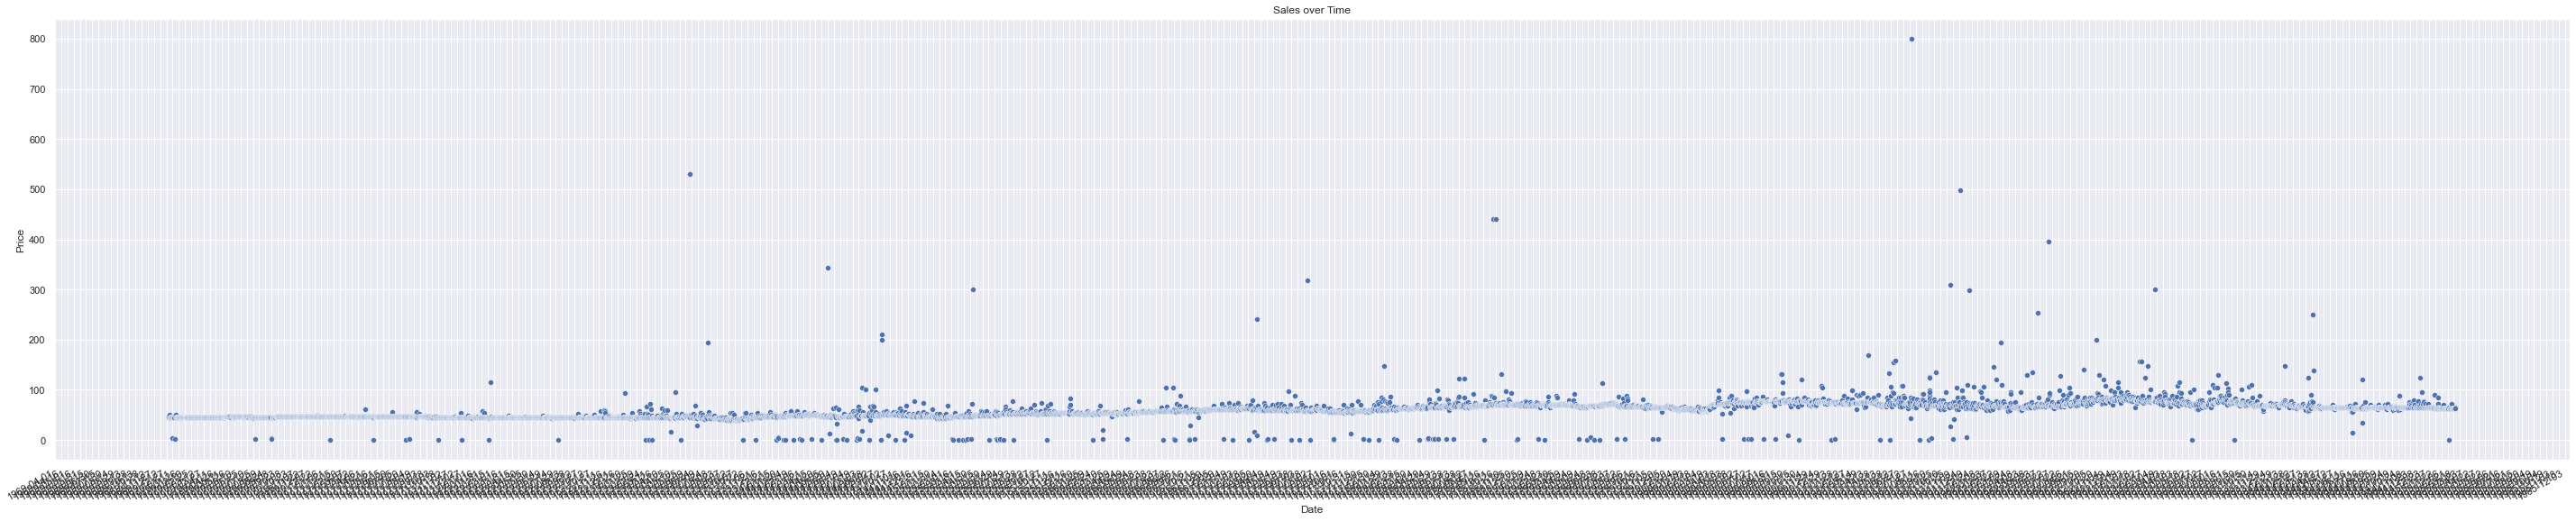

In [414]:
# Price destribution

plt.figure(figsize=(50,10))
sns.scatterplot(data=bayc_df, x='date', y='price')

plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Sales over Time')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=15))  
plt.gcf().autofmt_xdate() 

plt.show()


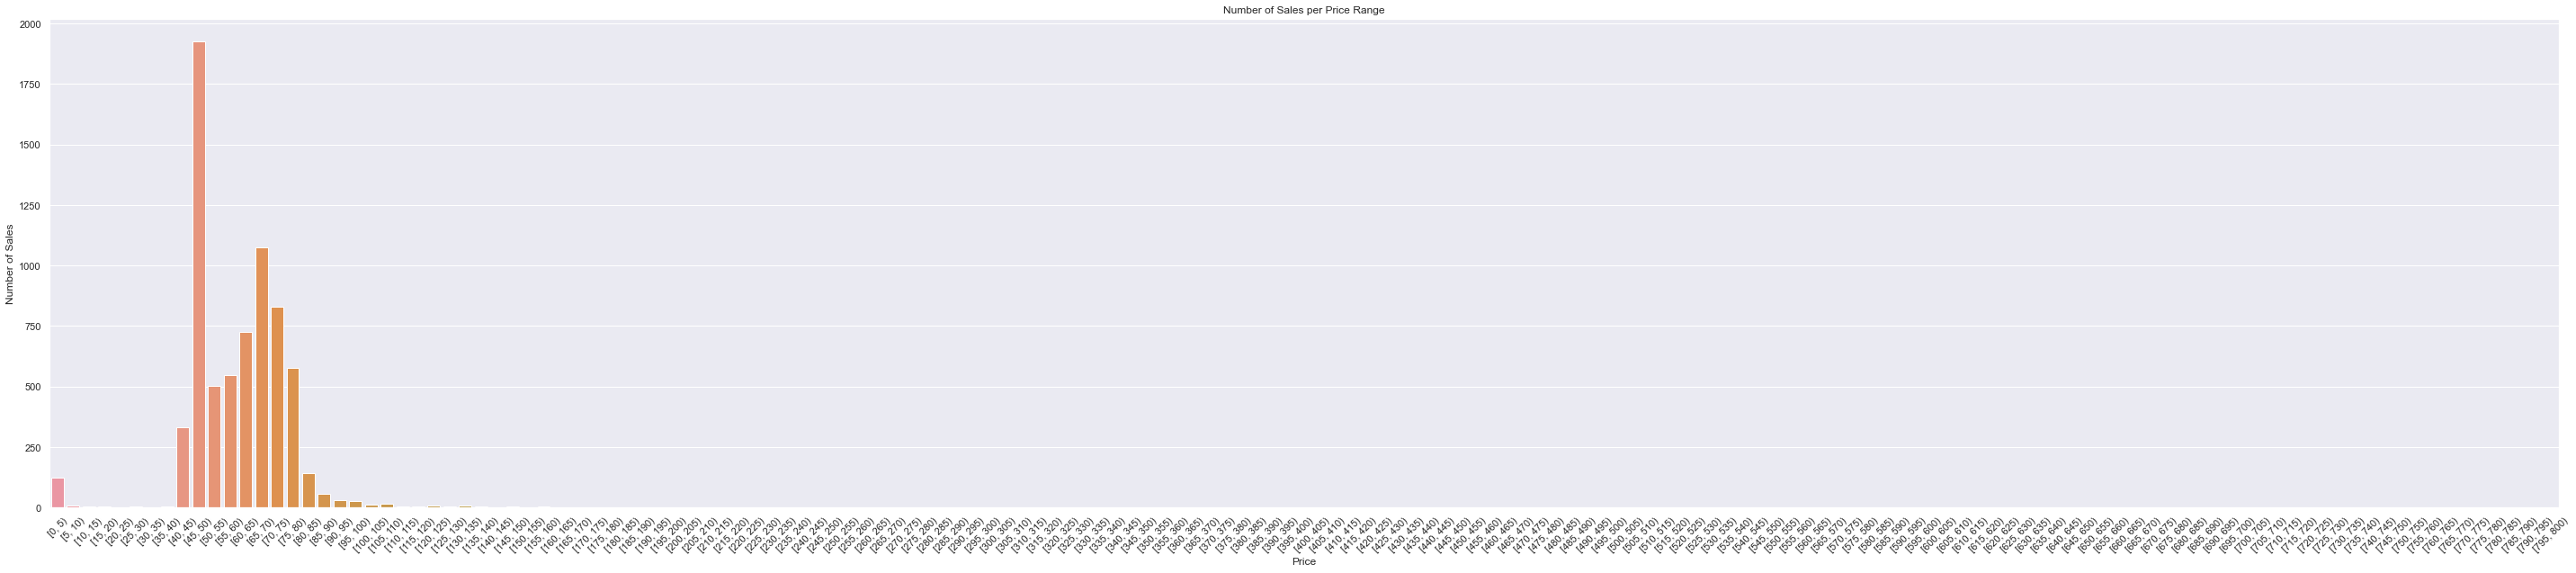

,price,count
9,"[0, 5)",122
16,"[5, 10)",7
22,"[10, 15)",4
21,"[15, 20)",4
27,"[25, 30)",3
46,"[30, 35)",1
18,"[35, 40)",6
7,"[40, 45)",333
0,"[45, 50)",1925
6,"[50, 55)",501


In [415]:
# Number of sales per price binned with step 5

bins = list(range(0, int(bayc_df['price'].max()) + 5, 5))

bayc_df['price_binned'] = pd.cut(bayc_df['price'], bins=bins, include_lowest=True, right=False)

price_counts = bayc_df['price_binned'].value_counts().reset_index()
price_counts.columns = ['price', 'count']
price_counts = price_counts[price_counts['count'] > 0]

plt.figure(figsize=(50,10))
sns.barplot(x='price', y='count', data=price_counts)
plt.xlabel('Price')
plt.ylabel('Number of Sales')
plt.title('Number of Sales per Price Range')
plt.xticks(rotation=45)
plt.show()

price_counts.sort_values('price', ascending=True)

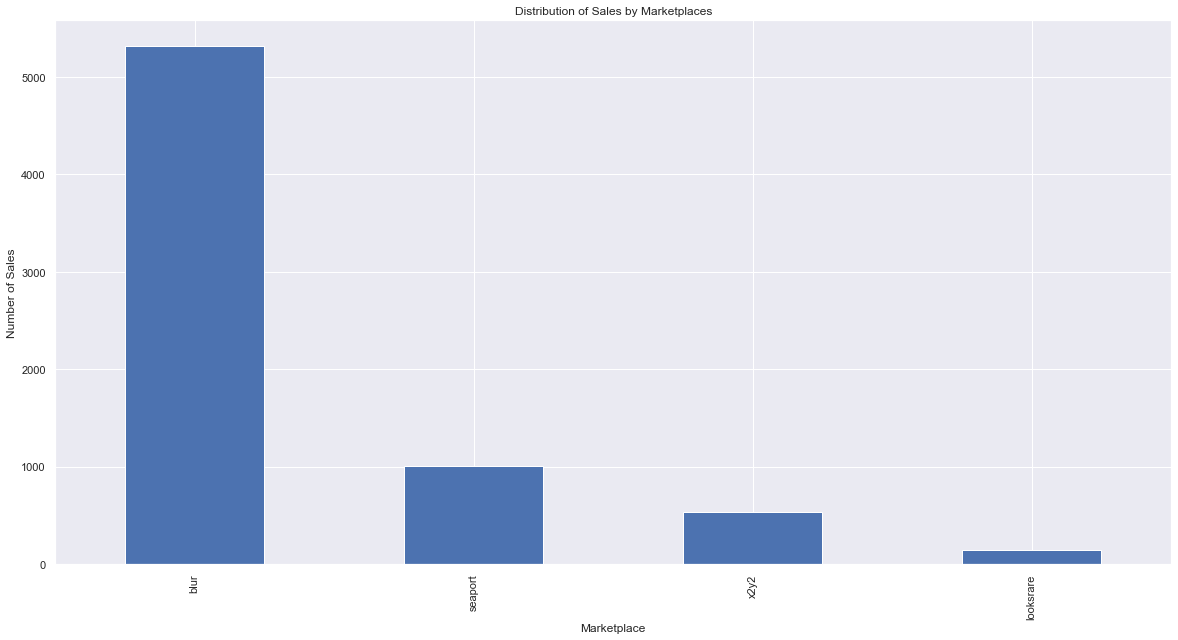

In [416]:
# Distribution of sales by marketplaces

plt.figure(figsize=(20,10))
bayc_df['marketplace'].value_counts().plot(kind='bar')
plt.xlabel('Marketplace')
plt.ylabel('Number of Sales')
plt.title('Distribution of Sales by Marketplaces')
plt.show()

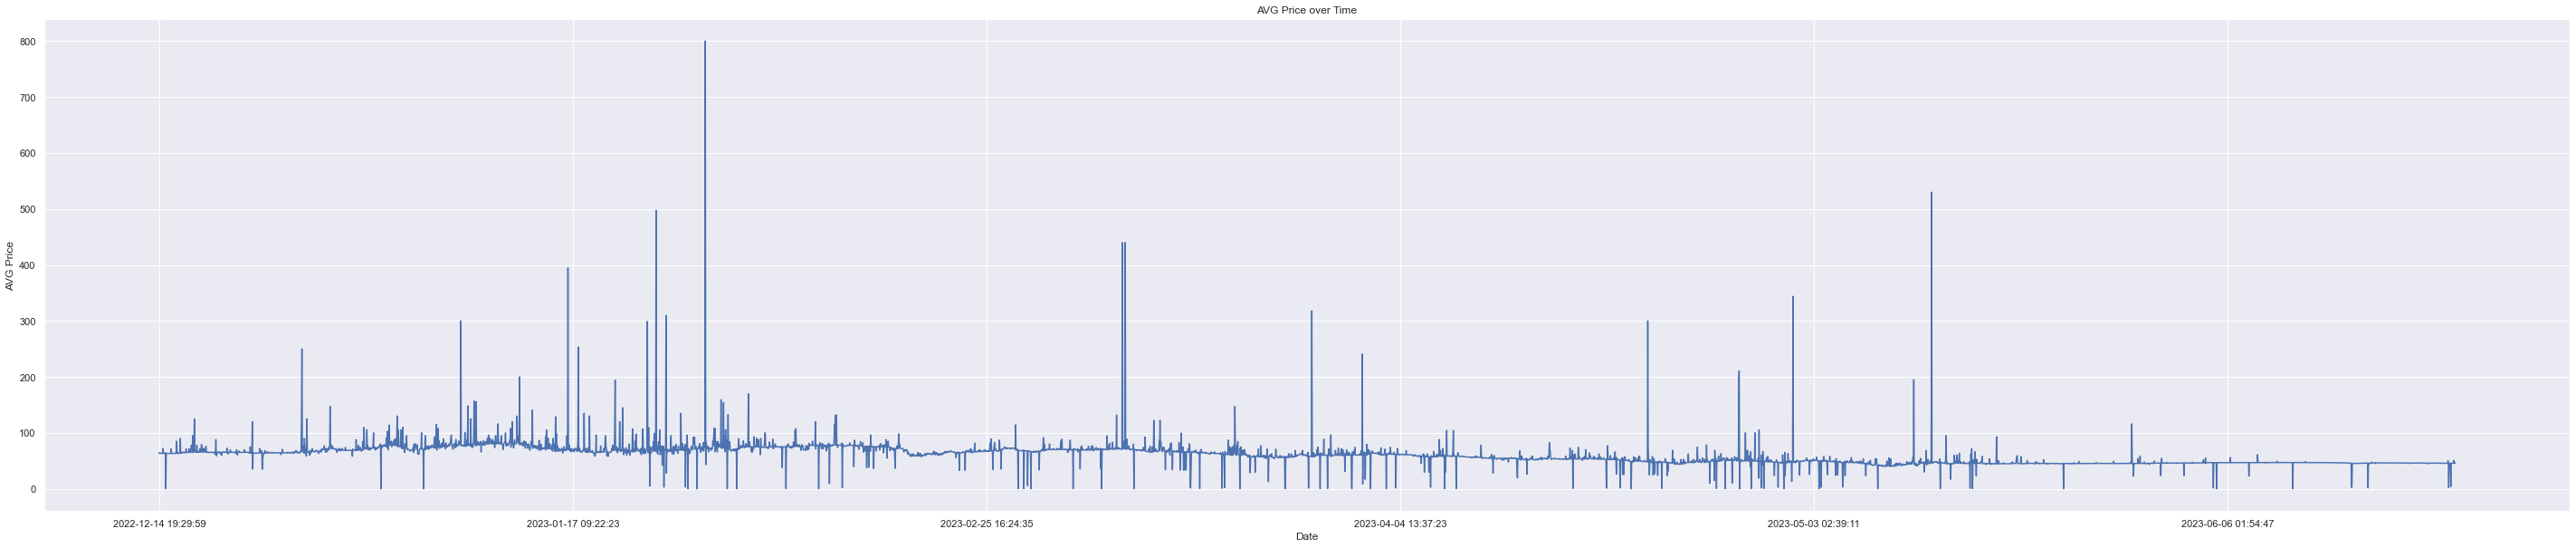

In [417]:
# AVG price over time

plt.figure(figsize=(50,10))
bayc_df.groupby('date')['price'].mean().plot()
plt.xlabel('Date')
plt.ylabel('AVG Price')
plt.title('AVG Price over Time')
plt.show()

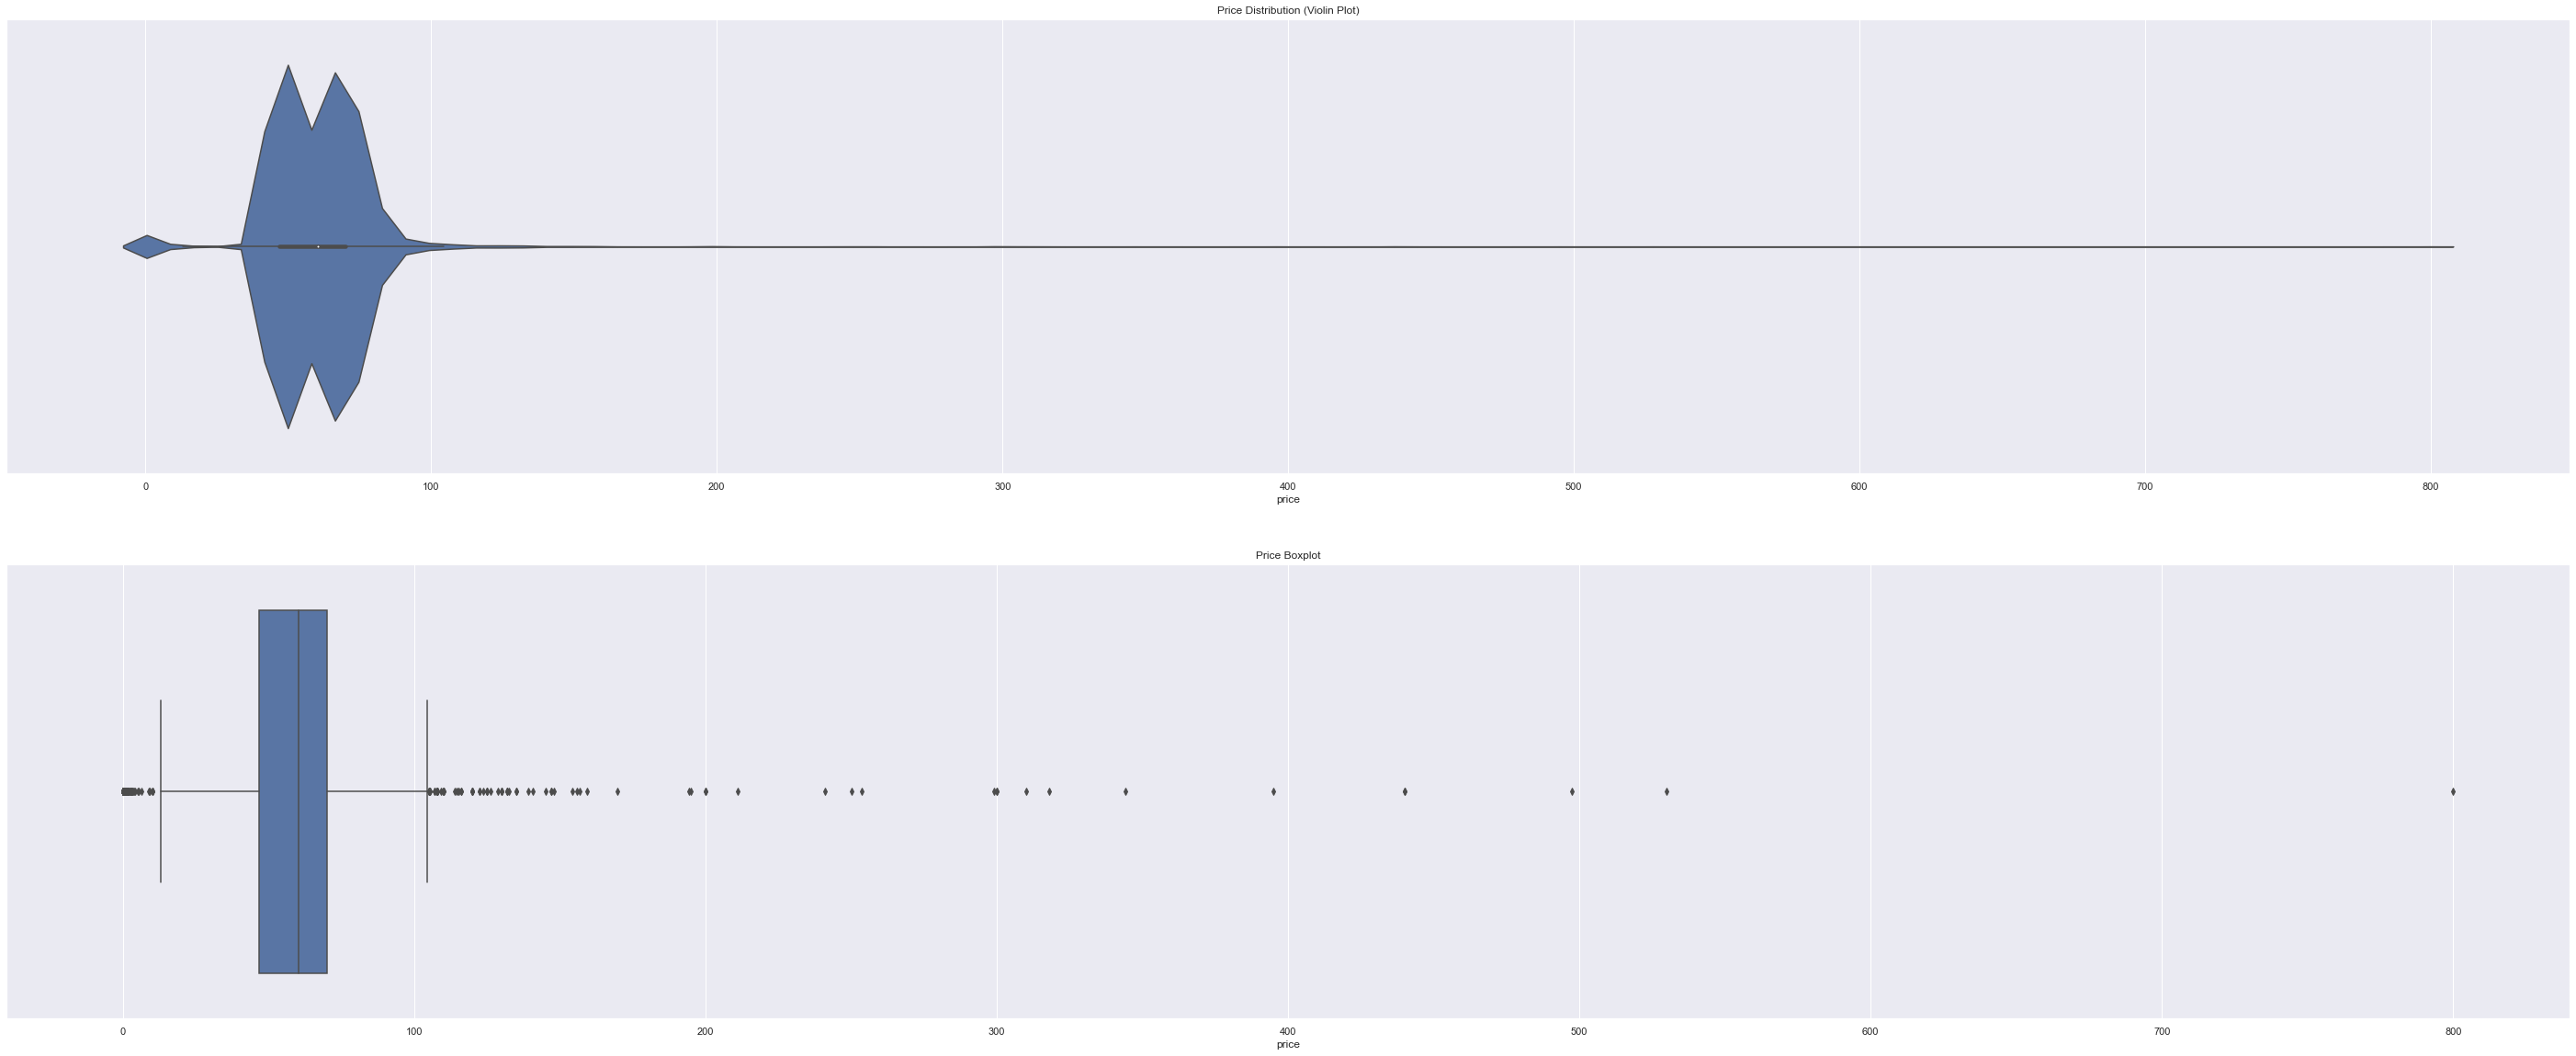

In [418]:
plt.figure(figsize=(50,20))

plt.subplot(2, 1, 1)
sns.violinplot(data=bayc_df, x='price')
plt.title('Price Distribution (Violin Plot)')

plt.subplot(2, 1, 2)
sns.boxplot(data=bayc_df, x='price')
plt.title('Price Boxplot')

plt.show()

# Outliers (1.5 IQR)

In [578]:
Q1 = bayc_df['price'].quantile(0.25)
Q3 = bayc_df['price'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

bayc_df_new = bayc_df[(bayc_df['price'] >= lower_bound) & (bayc_df['price'] <= upper_bound)]

print(f'Num of outliers: {len(bayc_df) - len(bayc_df_new)}')

Num of outliers: 205


In [579]:
bayc_df_new.describe()

,tokenId,block,price,rarity
count,6795.00,6795.00,6795.00,6795.00
mean,5016.53,16889855.16,60.00,7753868154.22
std,2876.34,396835.94,12.42,44929381715.73
min,27.00,16185032.00,12.94,165860.40
25%,2578.00,16645727.00,46.80,92587630.43
50%,4865.00,16897468.00,60.65,483669803.17
75%,7440.00,17256975.00,69.89,2671147596.58
max,9996.00,17452752.00,104.50,2135126471412.00


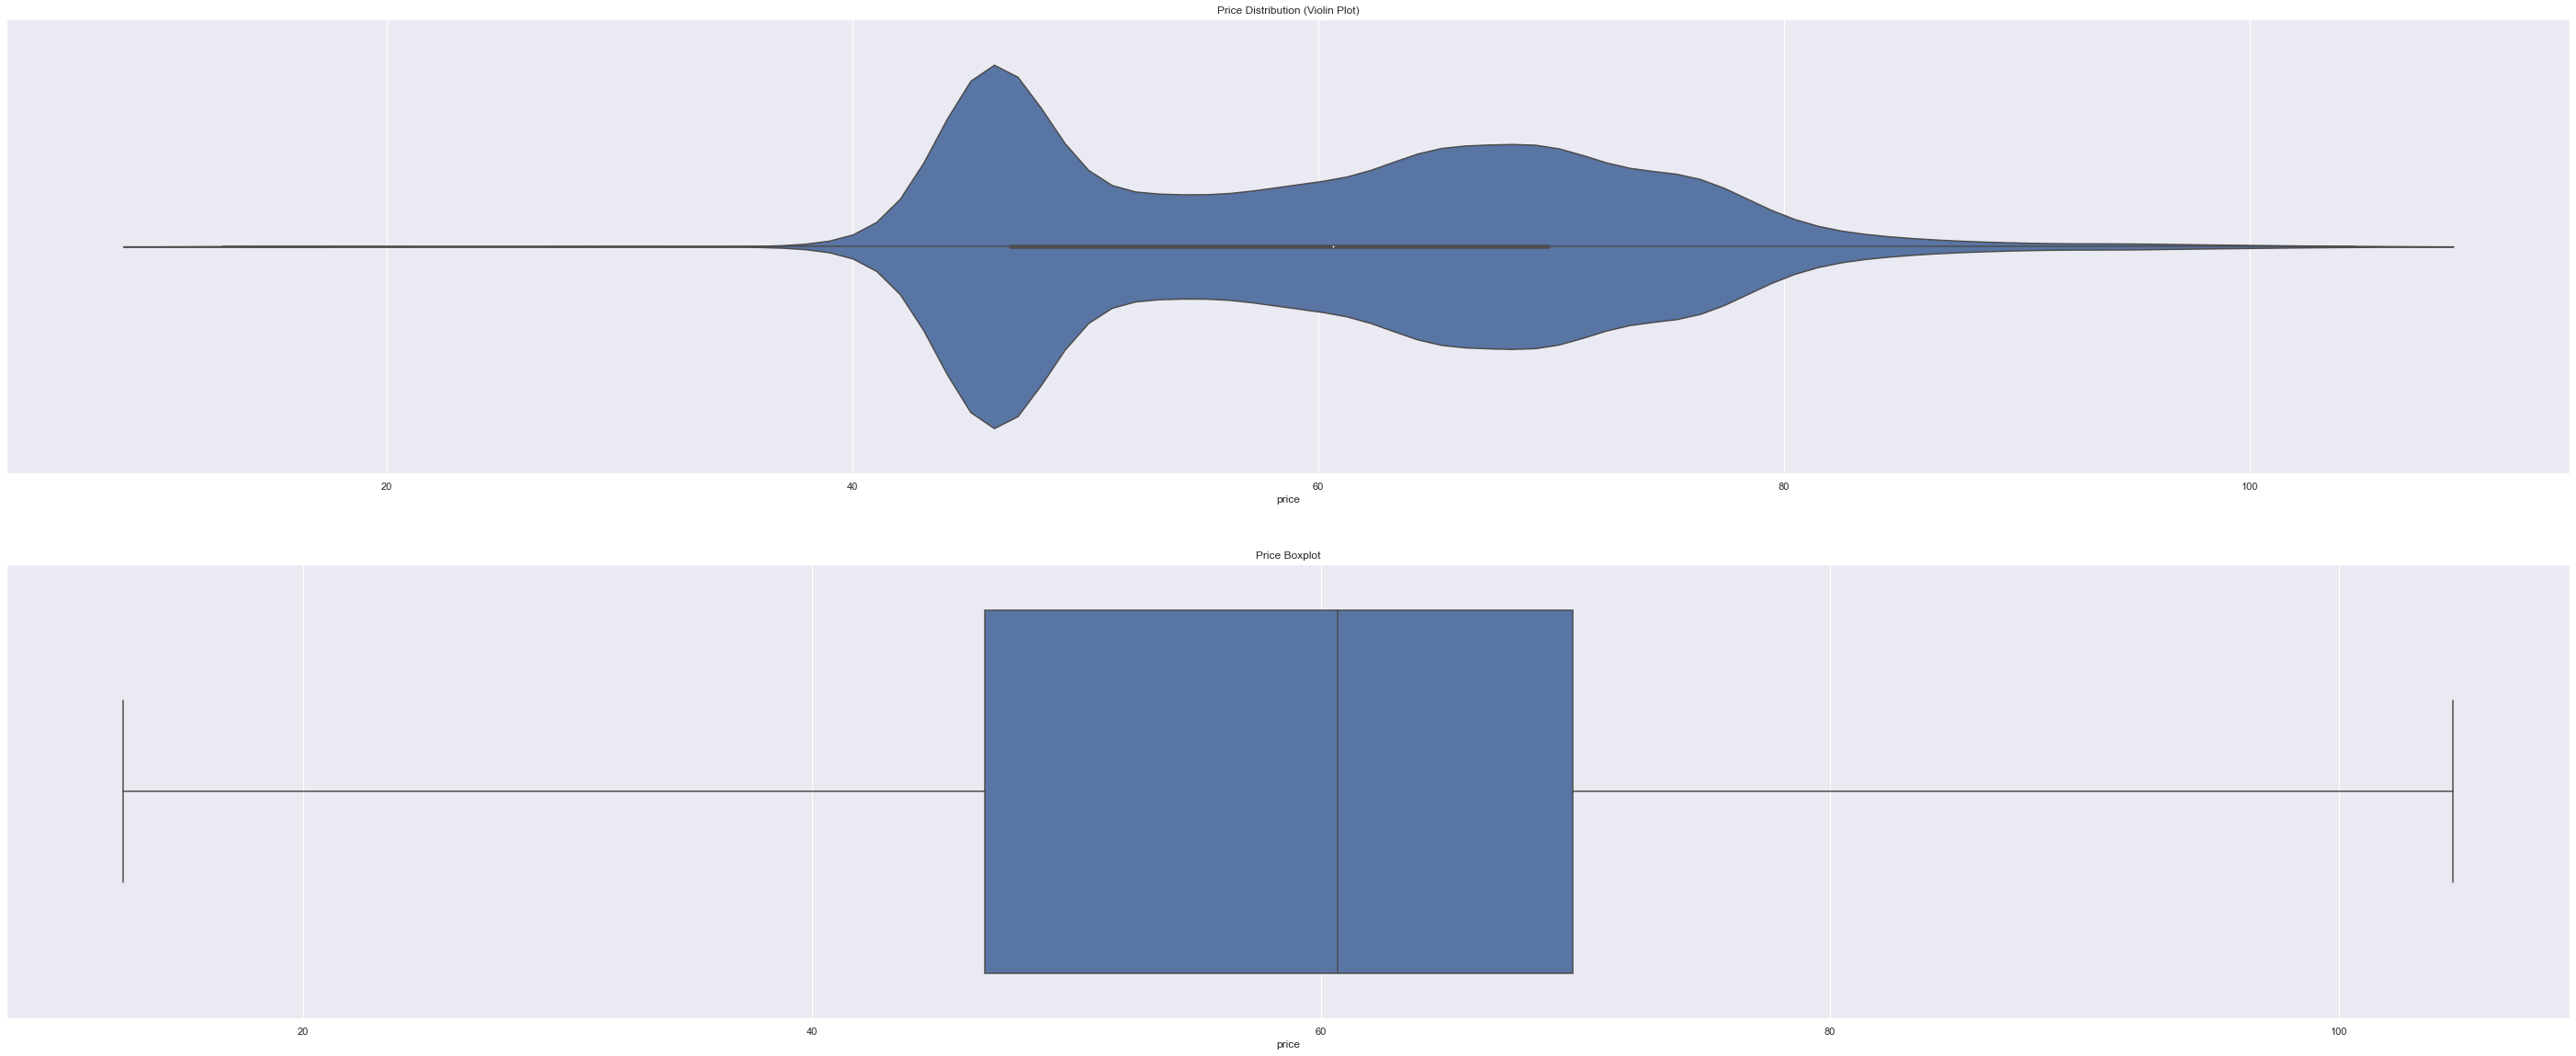

In [580]:
plt.figure(figsize=(50,20))

plt.subplot(2, 1, 1)
sns.violinplot(data=bayc_df_new, x='price')
plt.title('Price Distribution (Violin Plot)')

plt.subplot(2, 1, 2)
sns.boxplot(data=bayc_df_new, x='price')
plt.title('Price Boxplot')

plt.show()

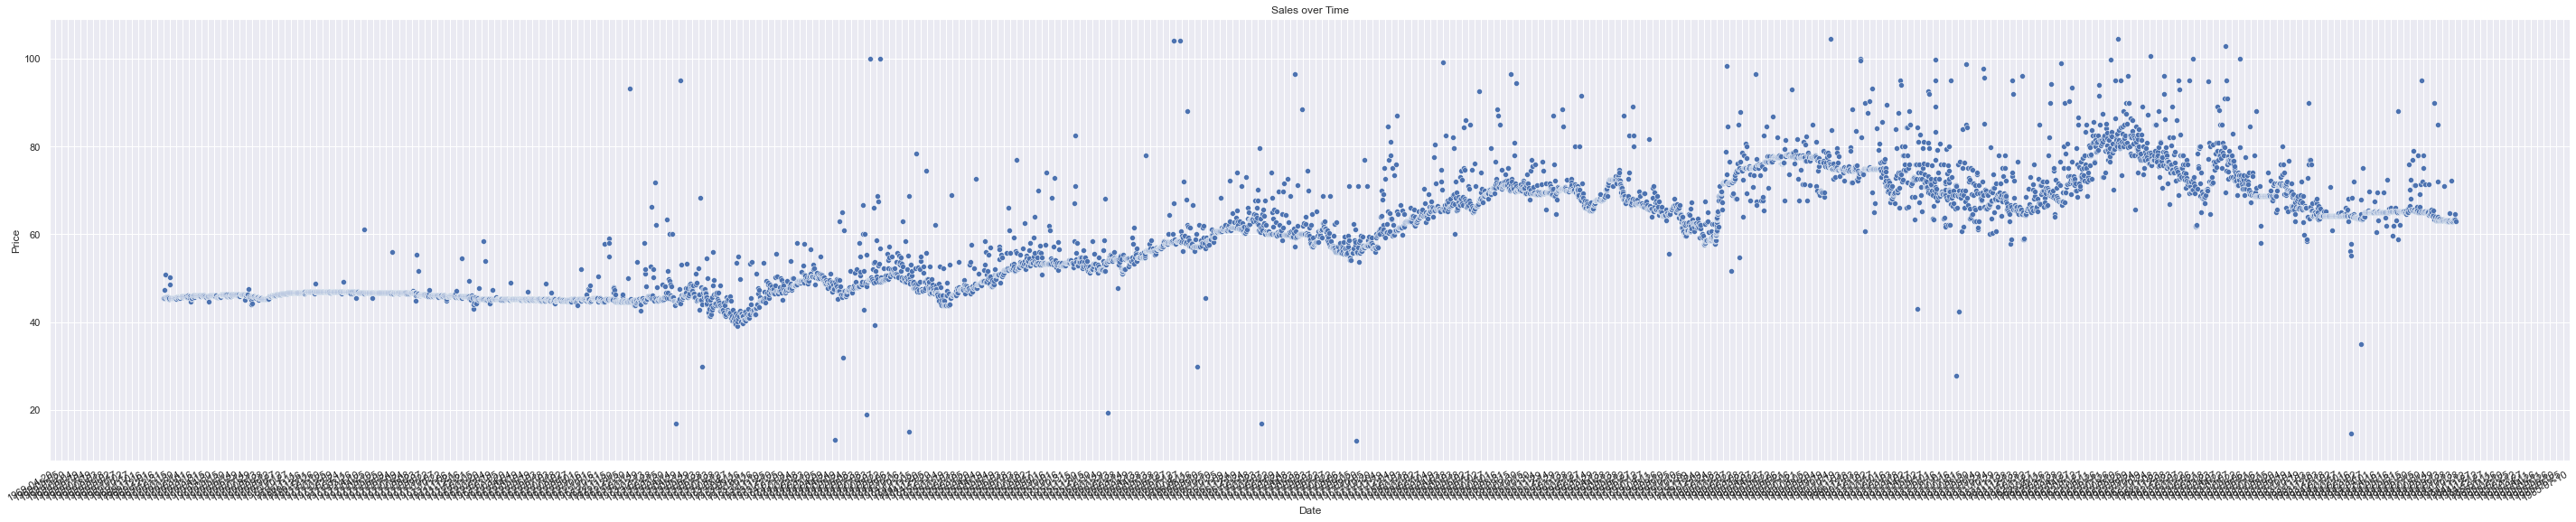

In [581]:
plt.figure(figsize=(50,10))
sns.scatterplot(data=bayc_df_new, x='date', y='price')

plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Sales over Time')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=15))  
plt.gcf().autofmt_xdate() 

plt.show()

# Time Series graphs

In [422]:
bayc_df_new['date'] = pd.to_datetime(bayc_df_new['date'])
bayc_df_new['date'] = bayc_df_new['date'].dt.strftime('%Y-%m-%d')
bayc_df_new['date'] = pd.to_datetime(bayc_df_new['date'])

start_date = bayc_df_new['date'].min()
end_date = bayc_df_new['date'].max()

all_dates_df = pd.DataFrame(pd.date_range(start_date, end_date), columns=['date'])
all_dates_df

grouped_df = bayc_df_new.groupby('date')['price'].mean().reset_index()

df_ts = pd.merge(all_dates_df, grouped_df, on='date', how='left')
df_ts['price'].fillna(method='ffill', inplace=True)
df_ts['date'] = df_ts['date'].dt.strftime('%Y-%m-%d')
df_ts.head(5)

,date,price
0,2022-12-14,63.35
1,2022-12-15,64.67
2,2022-12-16,67.31
3,2022-12-17,66.20
4,2022-12-18,64.85


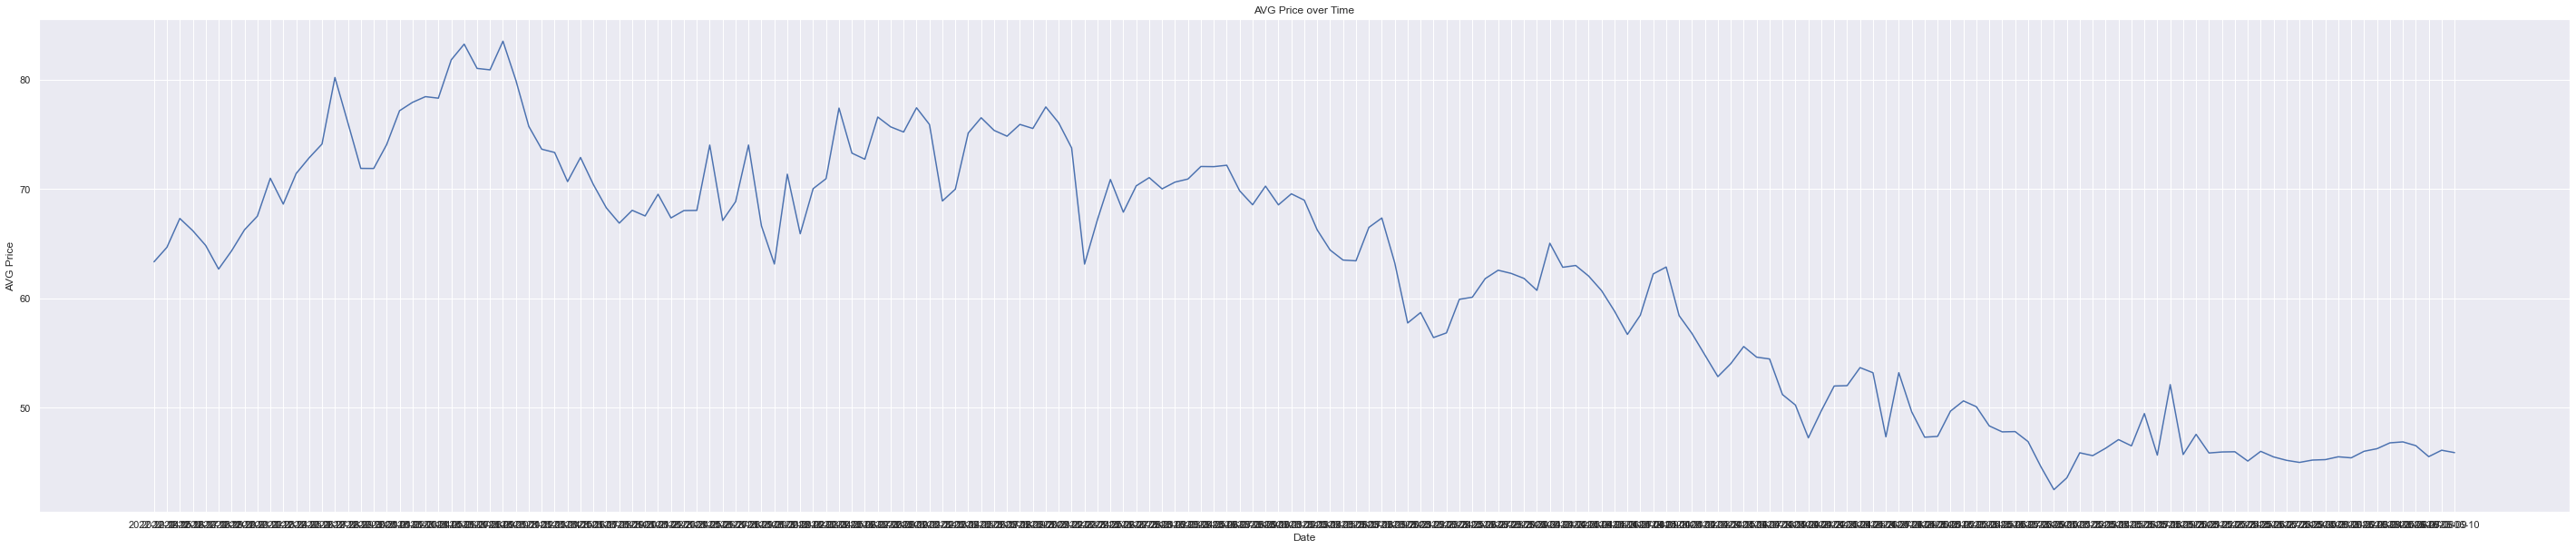

In [577]:
# AVG price over time

plt.figure(figsize=(50,10))
sns.lineplot(data=df_ts, x='date', y='price')
#bayc_df.groupby('date')['price'].mean().plot()
plt.xlabel('Date')
plt.ylabel('AVG Price')
plt.title('AVG Price over Time')
plt.show()

# Adding tech indicators

In [535]:
def calculate_indicators(df, lag):
    
    # Momentum Indicators
    df['roc'] = ta.momentum.ROCIndicator(close = df['price']).roc().shift(lag)
    df['rsi'] = ta.momentum.RSIIndicator(close = df['price']).rsi().shift(lag)
    df['stoch'] = ta.momentum.StochasticOscillator(high = df['price'], low = df['price'], close = df['price']).stoch().shift(lag)
    df['williams_r'] = ta.momentum.WilliamsRIndicator(high = df['price'], low = df['price'], close = df['price']).williams_r().shift(lag)

    # Volume Indicators
    df['obv'] = ta.volume.OnBalanceVolumeIndicator(close = df['price'], volume = df['price']).on_balance_volume().shift(lag)

    # Volatility Indicators
    df['atr'] = ta.volatility.AverageTrueRange(high = df['price'], low = df['price'], close = df['price']).average_true_range().shift(lag)
    df['bollinger_hband'] = ta.volatility.BollingerBands(close = df['price']).bollinger_hband().shift(lag)
    df['bollinger_lband'] = ta.volatility.BollingerBands(close = df['price']).bollinger_lband().shift(lag)

    # Trend Indicators
    df['macd'] = ta.trend.MACD(close = df['price']).macd().shift(lag)
    df['cci'] = ta.trend.cci(high = df['price'], low = df['price'], close = df['price']).shift(lag)
    df['ema_20'] = ta.trend.ema_indicator(df['price'], window=20).shift(lag)
    df['ema_100'] = ta.trend.ema_indicator(df['price'], window=100).shift(lag)

    return df


In [536]:
df = calculate_indicators(bayc_df_new, lag=2)

In [537]:
df.tail(5)

,tokenId,marketplace,block,token,price,rarity,date,roc,rsi,stoch,williams_r,obv,atr,bollinger_hband,bollinger_lband,macd,cci,ema_20,ema_100
6995,1971,blur,16185750,NaN,63.37,102484796.83,2022-12-14,0.38,48.31,3.10,-96.90,143024.20,1.66,67.62,59.55,-0.01,-29.90,63.82,65.01
6996,6582,blur,16185745,NaN,63.37,249065298.50,2022-12-14,0.83,48.86,5.56,-94.44,143087.57,1.55,67.62,59.57,-0.05,-15.42,63.78,64.98
6997,910,blur,16185661,NaN,63.37,23412942758.50,2022-12-14,-2.25,48.86,5.56,-94.44,143150.94,1.44,67.63,59.59,-0.07,-16.45,63.74,64.95
6998,3154,seaport,16185133,WETH,64.66,861691702.02,2022-12-14,0.43,48.86,4.54,-95.46,143214.31,1.34,67.64,59.61,-0.10,-17.63,63.70,64.92
6999,2193,blur,16185032,NaN,63.00,230580442.87,2022-12-14,0.67,48.86,4.54,-95.46,143277.68,1.24,67.65,59.63,-0.11,-18.68,63.67,64.89


# Regressions

# Full set w/o splitting by date

In [538]:
from sklearn.metrics import mean_absolute_percentage_error, accuracy_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

from sklearn.metrics import mean_squared_error
from math import sqrt

In [539]:
df_reg = df.drop(['tokenId', 'marketplace', 'block', 'token'], axis=1)

In [540]:
df_reg.tail(5)

,price,rarity,date,roc,rsi,stoch,williams_r,obv,atr,bollinger_hband,bollinger_lband,macd,cci,ema_20,ema_100
6995,63.37,102484796.83,2022-12-14,0.38,48.31,3.10,-96.90,143024.20,1.66,67.62,59.55,-0.01,-29.90,63.82,65.01
6996,63.37,249065298.50,2022-12-14,0.83,48.86,5.56,-94.44,143087.57,1.55,67.62,59.57,-0.05,-15.42,63.78,64.98
6997,63.37,23412942758.50,2022-12-14,-2.25,48.86,5.56,-94.44,143150.94,1.44,67.63,59.59,-0.07,-16.45,63.74,64.95
6998,64.66,861691702.02,2022-12-14,0.43,48.86,4.54,-95.46,143214.31,1.34,67.64,59.61,-0.10,-17.63,63.70,64.92
6999,63.00,230580442.87,2022-12-14,0.67,48.86,4.54,-95.46,143277.68,1.24,67.65,59.63,-0.11,-18.68,63.67,64.89


In [541]:
df_reg = df_reg[100:] # they are used to calculate first non-null value of EMA100, so for this parameter they are null
df_reg = df_reg.dropna()

In [542]:
train, test = df_reg[df_reg['date'] < '2023-04-25'], df_reg[df_reg['date'] >= '2023-04-25']
train = train.drop('date', axis=1)
test = test.drop('date', axis=1)

In [543]:
x_train = train.drop('price', axis=1)
y_train = train['price']

x_test = test.drop('price', axis=1)
y_test = test['price']

In [544]:
def rmse(y_true, y_pred):
    return sqrt(mean_squared_error(y_true, y_pred))

In [545]:
# RANF
print('RandomForestRegressor')
ranf = RandomForestRegressor()
ranf.fit(x_train, y_train)
pred_ranf = ranf.predict(x_test)
print(f'RMSE: {rmse(y_test, pred_ranf)}')
print(f'MAPE: {mean_absolute_percentage_error(y_test, pred_ranf)}')

# TREE
print('\nDecisionTreeRegressor')
tree = DecisionTreeRegressor()
tree.fit(x_train, y_train)
pred_tree = tree.predict(x_test)
print(f'RMSE: {rmse(y_test, pred_tree)}')
print(f'MAPE: {mean_absolute_percentage_error(y_test, pred_tree)}')

# XGB
print('\nXGBRegressor')
xgb = XGBRegressor()
xgb.fit(x_train, y_train)
pred_xgb = xgb.predict(x_test)
print(f'RMSE: {rmse(y_test, pred_xgb)}')
print(f'MAPE: {mean_absolute_percentage_error(y_test, pred_xgb)}')

# CAT
print('\nCatBoostRegressor')
cat = CatBoostRegressor()
cat.fit(x_train, y_train)
pred_cat = cat.predict(x_test)
print(f'RMSE: {rmse(y_test, pred_cat)}')
print(f'MAPE: {mean_absolute_percentage_error(y_test, pred_cat)}')

RandomForestRegressor
RMSE: 6.574513955854938
MAPE: 0.12654795297261748

DecisionTreeRegressor
RMSE: 9.530974089691716
MAPE: 0.17545208401689352

XGBRegressor
RMSE: 9.059810328422818
MAPE: 0.1797606909574637

CatBoostRegressor
Learning rate set to 0.052046
0:	learn: 9.2992301	total: 2.31ms	remaining: 2.31s
1:	learn: 8.9903211	total: 3.49ms	remaining: 1.74s
2:	learn: 8.6799201	total: 4.75ms	remaining: 1.58s
3:	learn: 8.3959093	total: 6.2ms	remaining: 1.54s
4:	learn: 8.1313844	total: 7.91ms	remaining: 1.57s
5:	learn: 7.8830531	total: 9.69ms	remaining: 1.6s
6:	learn: 7.6483344	total: 11.2ms	remaining: 1.59s
7:	learn: 7.4329199	total: 13ms	remaining: 1.61s
8:	learn: 7.2339335	total: 14.3ms	remaining: 1.57s
9:	learn: 7.0404241	total: 15.9ms	remaining: 1.57s
10:	learn: 6.8770188	total: 17.3ms	remaining: 1.56s
11:	learn: 6.7126299	total: 18.8ms	remaining: 1.54s
12:	learn: 6.5677112	total: 20.3ms	remaining: 1.54s
13:	learn: 6.4258536	total: 21.8ms	remaining: 1.54s
14:	learn: 6.2983988	total: 2

In [546]:
features = pd.DataFrame({'feature':x_train.columns, 'importance':cat.feature_importances_}).sort_values(by=['importance'], ascending=False)
prices = pd.DataFrame({'actual':y_test, 'predicted':pred_cat})
features

,feature,importance
11,ema_20,23.26
12,ema_100,14.49
5,obv,14.34
0,rarity,9.74
8,bollinger_lband,7.51
7,bollinger_hband,5.86
6,atr,5.05
9,macd,4.94
1,roc,4.05
2,rsi,3.81


In [ ]:
# DROP EMAs
# x_train = x_train.drop(['ema_20', 'ema_100'], axis=1)
# x_test = x_test.drop(['ema_20', 'ema_100'], axis=1)

In [522]:
prices['diff'] = abs(prices['predicted'] - prices['actual'])
prices

,actual,predicted,diff
116,45.99,51.56,5.57
117,46.01,49.92,3.91
118,46.02,52.54,6.52
119,46.02,50.47,4.45
120,46.02,54.58,8.56
...,...,...,...
2221,49.56,57.98,8.42
2222,49.56,49.85,0.29
2223,49.85,52.01,2.16
2224,50.70,50.15,0.55


# Splitted by date

In [550]:
bayc_info = pd.read_csv('bayc_raw_data.csv')
bayc_rarity = pd.read_csv('bayc_w_rarity.csv')
bayc_time = pd.read_csv('bayc_w_time.csv')

bayc_df = bayc_info.join(bayc_rarity[['tokenId', 'rarity']].set_index('tokenId'), on='tokenId', how='left')
bayc_df = bayc_df.join(bayc_time[['block', 'date']].set_index('block'), on='block', how='left')
bayc_df = bayc_df.drop('Unnamed: 0', axis=1)

Q1 = bayc_df['price'].quantile(0.25)
Q3 = bayc_df['price'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

bayc_df_new = bayc_df[(bayc_df['price'] >= lower_bound) & (bayc_df['price'] <= upper_bound)]

print(f'Num of outliers: {len(bayc_df) - len(bayc_df_new)}')

bayc_df_new['date'] = pd.to_datetime(bayc_df_new['date'])
bayc_df_new['date'] = bayc_df_new['date'].dt.strftime('%Y-%m-%d')
bayc_df_new['date'] = pd.to_datetime(bayc_df_new['date'])

start_date = bayc_df_new['date'].min()
end_date = bayc_df_new['date'].max()

all_dates_df = pd.DataFrame(pd.date_range(start_date, end_date), columns=['date'])
all_dates_df

grouped_df = bayc_df_new.groupby('date')['price'].mean().reset_index()

df_ts = pd.merge(all_dates_df, grouped_df, on='date', how='left')
df_ts['price'].fillna(method='ffill', inplace=True)
df_ts['date'] = df_ts['date'].dt.strftime('%Y-%m-%d')
df_ts.head(5)

Num of outliers: 205


,date,price
0,2022-12-14,63.35
1,2022-12-15,64.67
2,2022-12-16,67.31
3,2022-12-17,66.20
4,2022-12-18,64.85


In [573]:
df_ts_reg = calculate_indicators(df_ts, lag=1)
df_ts_reg = df_ts_reg[110:] # they are used to calculate first non-null value of EMA100, so for this parameter they are null

In [574]:
train, test = df_ts_reg[df_ts_reg['date'] < '2023-04-25'], df_ts_reg[df_ts_reg['date'] >= '2023-04-25']
train = train.drop('date', axis=1)
test = test.drop('date', axis=1)

x_train = train.drop('price', axis=1)
y_train = train['price']

x_test = test.drop('price', axis=1)
y_test = test['price']

In [575]:
# RANF
print('RandomForestRegressor')
ranf = RandomForestRegressor()
ranf.fit(x_train, y_train)
pred_ranf = ranf.predict(x_test)
print(f'RMSE: {rmse(y_test, pred_ranf)}')
print(f'MAPE: {mean_absolute_percentage_error(y_test, pred_ranf)}')

# TREE
print('\nDecisionTreeRegressor')
tree = DecisionTreeRegressor()
tree.fit(x_train, y_train)
pred_tree = tree.predict(x_test)
print(f'RMSE: {rmse(y_test, pred_tree)}')
print(f'MAPE: {mean_absolute_percentage_error(y_test, pred_tree)}')

# XGB
print('\nXGBRegressor')
xgb = XGBRegressor()
xgb.fit(x_train, y_train)
pred_xgb = xgb.predict(x_test)
print(f'RMSE: {rmse(y_test, pred_xgb)}')
print(f'MAPE: {mean_absolute_percentage_error(y_test, pred_xgb)}')

# CAT
print('\nCatBoostRegressor')
cat = CatBoostRegressor()
cat.fit(x_train, y_train)
pred_cat = cat.predict(x_test)
print(f'RMSE: {rmse(y_test, pred_cat)}')
print(f'MAPE: {mean_absolute_percentage_error(y_test, pred_cat)}')

RandomForestRegressor
RMSE: 6.025047485941795
MAPE: 0.12166771767364193

DecisionTreeRegressor
RMSE: 5.311662173385625
MAPE: 0.10587157304987668

XGBRegressor
RMSE: 4.640890944570152
MAPE: 0.0925955914186536

CatBoostRegressor
Learning rate set to 0.022402
0:	learn: 4.4279972	total: 1.76ms	remaining: 1.76s
1:	learn: 4.3978261	total: 2ms	remaining: 1000ms
2:	learn: 4.3532792	total: 2.18ms	remaining: 724ms
3:	learn: 4.3097279	total: 2.57ms	remaining: 640ms
4:	learn: 4.2715877	total: 2.82ms	remaining: 561ms
5:	learn: 4.2211684	total: 2.93ms	remaining: 486ms
6:	learn: 4.1830463	total: 3.81ms	remaining: 541ms
7:	learn: 4.1330080	total: 3.89ms	remaining: 483ms
8:	learn: 4.0957388	total: 4.07ms	remaining: 448ms
9:	learn: 4.0598630	total: 4.22ms	remaining: 418ms
10:	learn: 4.0218584	total: 4.41ms	remaining: 397ms
11:	learn: 3.9901543	total: 4.65ms	remaining: 383ms
12:	learn: 3.9625134	total: 4.82ms	remaining: 366ms
13:	learn: 3.9240202	total: 4.98ms	remaining: 351ms
14:	learn: 3.8959823	total:

In [572]:
features = pd.DataFrame({'feature':x_train.columns, 'importance':cat.feature_importances_}).sort_values(by=['importance'], ascending=False)
prices = pd.DataFrame({'actual':y_test, 'predicted':pred_cat})
features

,feature,importance
10,ema_20,15.65
8,macd,13.08
7,bollinger_lband,11.69
0,roc,9.70
11,ema_100,8.96
2,stoch,8.58
1,rsi,8.04
3,williams_r,7.23
4,obv,6.54
5,atr,4.25


In [568]:
prices['diff'] = abs(prices['predicted'] - prices['actual'])
prices

,actual,predicted,diff
132,53.67,53.48,0.19
133,53.20,55.05,1.85
134,47.34,54.97,7.63
135,53.20,51.77,1.44
136,49.62,54.86,5.24
137,47.31,52.62,5.32
138,47.38,51.99,4.61
139,49.69,52.20,2.51
140,50.63,54.22,3.59
141,50.09,54.93,4.84


# Time Series

In [475]:
bayc_info = pd.read_csv('bayc_raw_data.csv')
bayc_rarity = pd.read_csv('bayc_w_rarity.csv')
bayc_time = pd.read_csv('bayc_w_time.csv')

bayc_df = bayc_info.join(bayc_rarity[['tokenId', 'rarity']].set_index('tokenId'), on='tokenId', how='left')
bayc_df = bayc_df.join(bayc_time[['block', 'date']].set_index('block'), on='block', how='left')
bayc_df = bayc_df.drop('Unnamed: 0', axis=1)

Q1 = bayc_df['price'].quantile(0.25)
Q3 = bayc_df['price'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

bayc_df_new = bayc_df[(bayc_df['price'] >= lower_bound) & (bayc_df['price'] <= upper_bound)]

print(f'Num of outliers: {len(bayc_df) - len(bayc_df_new)}')

bayc_df_new['date'] = pd.to_datetime(bayc_df_new['date'])
bayc_df_new['date'] = bayc_df_new['date'].dt.strftime('%Y-%m-%d')
bayc_df_new['date'] = pd.to_datetime(bayc_df_new['date'])

start_date = bayc_df_new['date'].min()
end_date = bayc_df_new['date'].max()

all_dates_df = pd.DataFrame(pd.date_range(start_date, end_date), columns=['date'])
all_dates_df

grouped_df = bayc_df_new.groupby('date')['price'].mean().reset_index()

df_ts = pd.merge(all_dates_df, grouped_df, on='date', how='left')
df_ts['price'].fillna(method='ffill', inplace=True)
df_ts['date'] = df_ts['date'].dt.strftime('%Y-%m-%d')
df_ts.head(5)

Num of outliers: 205


,date,price
0,2022-12-14,63.35
1,2022-12-15,64.67
2,2022-12-16,67.31
3,2022-12-17,66.20
4,2022-12-18,64.85


In [476]:
from statsmodels.tsa.arima.model import ARIMA

df_ts['date'] = pd.to_datetime(df_ts['date'])
df_ts.set_index('date', inplace=True)

train = df_ts['2023-01-01':'2023-04-25']
test = df_ts['2023-04-25':]

In [477]:
model = ARIMA(train['price'], order=(5,1,0))
model_fit = model.fit()

start_date = test.index.min()
end_date = test.index.max()
forecast = model_fit.predict(start=start_date, end=end_date)

In [478]:
ts_res = test.join(forecast, how='left')
ts_res['diff'] = abs(ts_res['price'] - ts_res['predicted_mean'])
ts_res

,price,predicted_mean,diff
date,,,
2023-04-25,53.67,51.83,1.84
2023-04-26,53.20,53.81,0.61
2023-04-27,47.34,52.81,5.47
2023-04-28,53.20,52.45,0.75
2023-04-29,49.62,52.64,3.02
2023-04-30,47.31,52.35,5.05
2023-05-01,47.38,52.40,5.02
2023-05-02,49.69,52.67,2.98
2023-05-03,50.63,52.68,2.05


# New try with other indicators

In [486]:
bayc_info = pd.read_csv('bayc_raw_data.csv')
bayc_rarity = pd.read_csv('bayc_w_rarity.csv')
bayc_time = pd.read_csv('bayc_w_time.csv')

bayc_df = bayc_info.join(bayc_rarity[['tokenId', 'rarity']].set_index('tokenId'), on='tokenId', how='left')
bayc_df = bayc_df.join(bayc_time[['block', 'date']].set_index('block'), on='block', how='left')
bayc_df = bayc_df.drop('Unnamed: 0', axis=1)

Q1 = bayc_df['price'].quantile(0.25)
Q3 = bayc_df['price'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

bayc_df_new = bayc_df[(bayc_df['price'] >= lower_bound) & (bayc_df['price'] <= upper_bound)]

print(f'Num of outliers: {len(bayc_df) - len(bayc_df_new)}')

Num of outliers: 205


,date,price
0,2022-12-14,63.35
1,2022-12-15,64.67
2,2022-12-16,67.31
3,2022-12-17,66.20
4,2022-12-18,64.85


In [488]:
data = df_ts.copy()
data['date'] = pd.to_datetime(data['date'])
data.set_index('date', inplace=True)

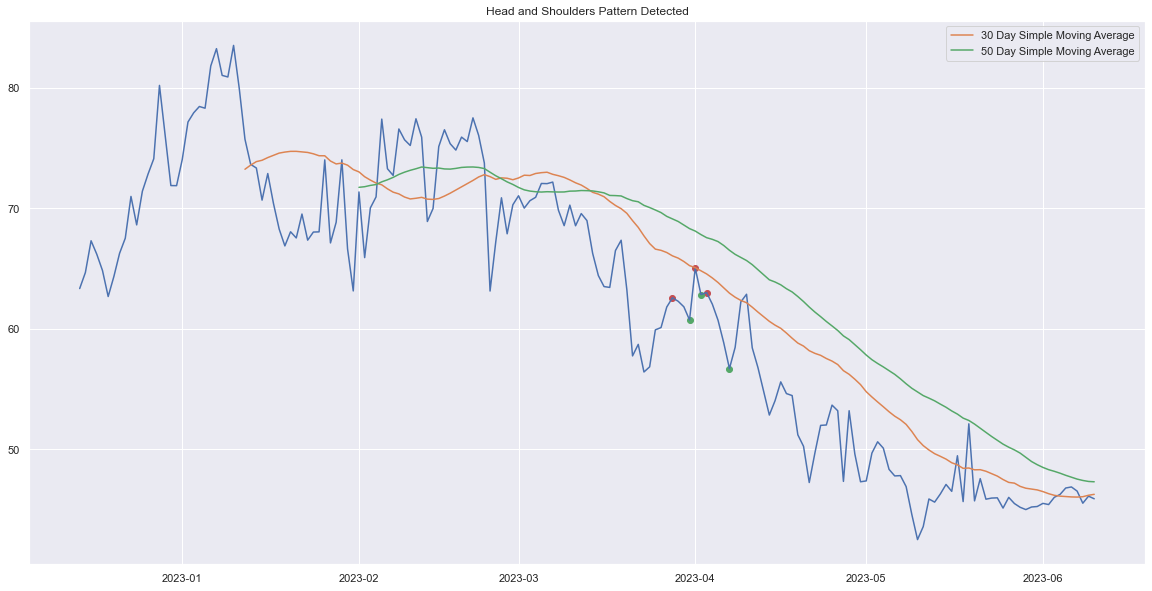

Head and Shoulders Pattern Detected: True


In [500]:
from scipy.signal import argrelextrema

def head_and_shoulders(data, col_name='price', plot=False):
 
    sma30 = data[col_name].rolling(window=30).mean()
    sma50 = data[col_name].rolling(window=50).mean()

    comparator = np.greater

    peaks = argrelextrema(data[col_name].values, comparator)

    comparator = np.less

    valleys = argrelextrema(data[col_name].values, comparator)

    peak_dates = data.iloc[peaks].index
    valley_dates = data.iloc[valleys].index

    for i in range(1, len(peak_dates)-1):
        if data[col_name][peak_dates[i-1]] < data[col_name][peak_dates[i]] > data[col_name][peak_dates[i+1]]:
            if data[col_name][valley_dates[i]] > data[col_name][valley_dates[i-1]] and data[col_name][valley_dates[i]] > data[col_name][valley_dates[i+1]]:
                if plot:
                    plt.figure(figsize=(20,10))
                    plt.plot(data[col_name])
                    plt.plot(sma30, label='30 Day Simple Moving Average')
                    plt.plot(sma50, label='50 Day Simple Moving Average')
                    plt.scatter([peak_dates[i-1], peak_dates[i], peak_dates[i+1]], 
                                [data[col_name][peak_dates[i-1]], data[col_name][peak_dates[i]], data[col_name][peak_dates[i+1]]],
                                color='r')
                    plt.scatter([valley_dates[i-1], valley_dates[i], valley_dates[i+1]], 
                                [data[col_name][valley_dates[i-1]], data[col_name][valley_dates[i]], data[col_name][valley_dates[i+1]]],
                                color='g')
                    plt.legend()
                    plt.title('Head and Shoulders Pattern Detected')
                    plt.show()
                return True
    return False

result = head_and_shoulders(data, 'price', plot=True)

print('Head and Shoulders Pattern Detected:', result)

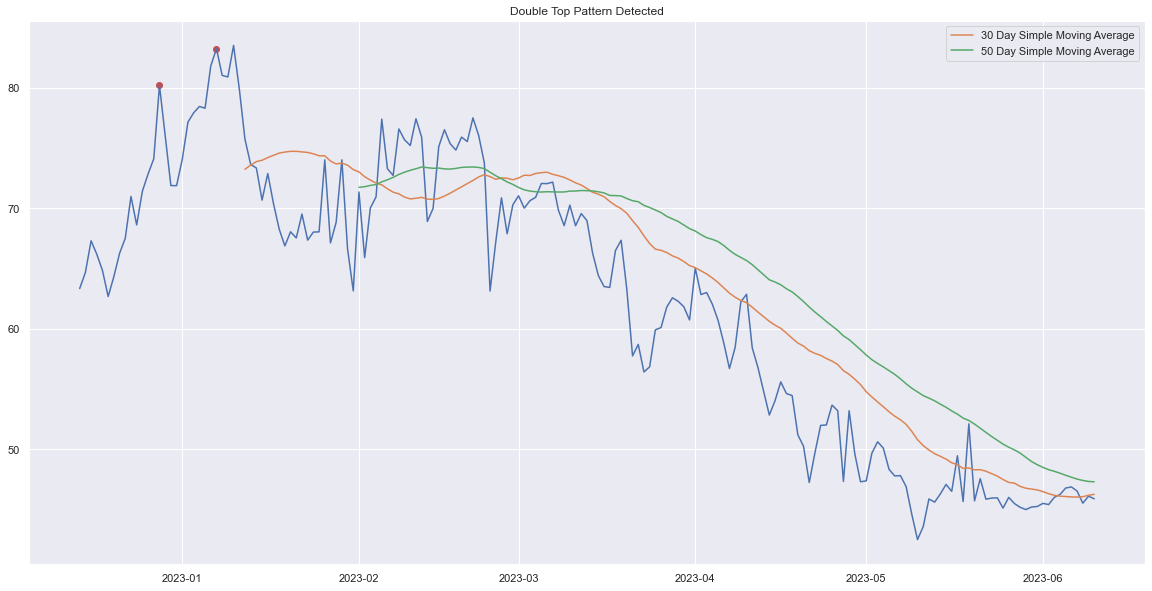

Double Top or Double Bottom Pattern Detected: True


In [503]:
def double_top_bottom(data, col_name='price', plot=False):

    sma30 = data[col_name].rolling(window=30).mean()
    sma50 = data[col_name].rolling(window=50).mean()

    comparator = np.greater


    peaks = argrelextrema(data[col_name].values, comparator)


    comparator = np.less


    valleys = argrelextrema(data[col_name].values, comparator)

    peak_dates = data.iloc[peaks].index
    valley_dates = data.iloc[valleys].index

    for i in range(1, len(peak_dates)-1):
        if np.isclose(data[col_name][peak_dates[i-1]], data[col_name][peak_dates[i+1]], rtol=0.05):
            if plot:
                plt.figure(figsize=(20,10))
                plt.plot(data[col_name])
                plt.plot(sma30, label='30 Day Simple Moving Average')
                plt.plot(sma50, label='50 Day Simple Moving Average')
                plt.scatter([peak_dates[i-1], peak_dates[i+1]], 
                            [data[col_name][peak_dates[i-1]], data[col_name][peak_dates[i+1]]],
                            color='r')
                plt.legend()
                plt.title('Double Top Pattern Detected')
                plt.show()
            return True

    for i in range(1, len(valley_dates)-1):
        if np.isclose(data[col_name][valley_dates[i-1]], data[col_name][valley_dates[i+1]], rtol=0.05):
            if plot:
                plt.figure(figsize=(20,10))
                plt.plot(data[col_name])
                plt.plot(sma30, label='30 Day Simple Moving Average')
                plt.plot(sma50, label='50 Day Simple Moving Average')
                plt.scatter([valley_dates[i-1], valley_dates[i+1]], 
                            [data[col_name][valley_dates[i-1]], data[col_name][valley_dates[i+1]]],
                            color='r')
                plt.legend()
                plt.title('Double Bottom Pattern Detected')
                plt.show()
            return True

    return False

result = double_top_bottom(data, 'price', plot=True)

print('Double Top or Double Bottom Pattern Detected:', result)


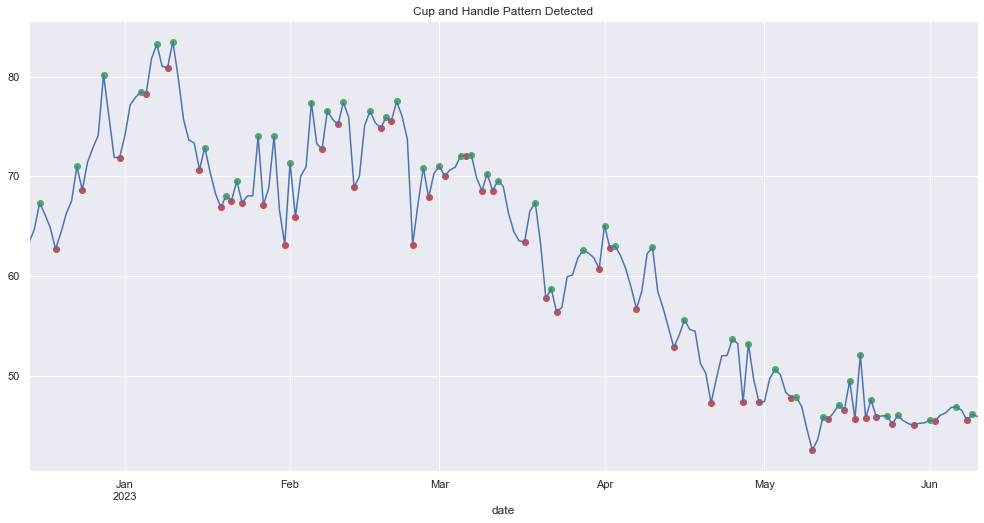

Cup and Handle Pattern Detected: True


In [505]:
def cup_and_handle(data, col_name='avg_price', plot=False):
    comparator = np.less

    valleys = argrelextrema(data[col_name].values, comparator)
    
    comparator = np.greater

    peaks = argrelextrema(data[col_name].values, comparator)

    valley_dates = data.iloc[valleys].index
    peak_dates = data.iloc[peaks].index

    for i in range(1, len(valley_dates)-1):
        if valley_dates[i-1] < valley_dates[i] < valley_dates[i+1]:
            for j in range(1, len(peak_dates)-1):
                if peak_dates[j-1] < peak_dates[j] < peak_dates[j+1]:
                    if np.isclose(data[col_name][valley_dates[i]], data[col_name][valley_dates[i+1]], rtol=0.05):
                        if plot:
                            data[col_name].plot()
                            plt.scatter(valley_dates, data[col_name][valley_dates], color='r')
                            plt.scatter(peak_dates, data[col_name][peak_dates], color='g')
                            plt.title('Cup and Handle Pattern Detected')
                            plt.show()
                        return True
    return False

result = cup_and_handle(data, 'price', plot=True)

print('Cup and Handle Pattern Detected:', result)

# Deleted stuff which may be helpful

In [ ]:
# OLD w/o LAG

# def calculate_indicators(df):
    
#     # Momentum Indicators
#     df['roc'] = ta.momentum.ROCIndicator(close = df['price']).roc()
#     df['rsi'] = ta.momentum.RSIIndicator(close = df['price']).rsi()
#     df['stoch'] = ta.momentum.StochasticOscillator(high = df['price'], low = df['price'], close = df['price']).stoch()
#     df['williams_r'] = ta.momentum.WilliamsRIndicator(high = df['price'], low = df['price'], close = df['price']).williams_r()

#     # Volume Indicators
#     df['obv'] = ta.volume.OnBalanceVolumeIndicator(close = df['price'], volume = df['price']).on_balance_volume()

#     # Volatility Indicators
#     df['atr'] = ta.volatility.AverageTrueRange(high = df['price'], low = df['price'], close = df['price']).average_true_range()
#     df['bollinger_hband'] = ta.volatility.BollingerBands(close = df['price']).bollinger_hband()
#     df['bollinger_lband'] = ta.volatility.BollingerBands(close = df['price']).bollinger_lband()

#     # Trend Indicators
#     df['macd'] = ta.trend.MACD(close = df['price']).macd()
#     df['cci'] = ta.trend.cci(high = df['price'], low = df['price'], close = df['price'])
#     # df['sma_20'] = ta.trend.sma_indicator(df['price'], window=20)
#     # df['sma_100'] = ta.trend.sma_indicator(df['price'], window=100)
#     df['ema_20'] = ta.trend.ema_indicator(df['price'], window=20)
#     df['ema_100'] = ta.trend.ema_indicator(df['price'], window=100)

#     return df

In [ ]:
# def calculate_intersections(df):
#     # sma crossover
#     df['signal_sma'] = 'buy'
#     df.loc[df['SMA_10'] < df['SMA_20'], 'signal_sma'] = 'sell'

#     # df['signal_sma'] = 'no signal'
#     # df['sma_diff'] = df['SMA_10'] - df['SMA_20']
#     # df.loc[(df['sma_diff'] > 0) & (df['sma_diff'].shift(1) < 0), 'signal_sma'] = 'buy'
#     # df.loc[(df['sma_diff'] < 0) & (df['sma_diff'].shift(1) > 0), 'signal_sma'] = 'sell'

#     # ema crossover
#     df['signal_ema'] = 'buy'
#     df.loc[df['EMA_10'] < df['EMA_20'], 'signal_ema'] = 'sell'

#     # macd and rsi
#     df['mr_signal'] = 'no signal'
#     df.loc[(df['MACD'] > 0) & (df['RSI'] < 30), 'mr_signal'] = 'buy'
#     df.loc[(df['MACD'] < 0) & (df['RSI'] > 70), 'mr_signal'] = 'sell'

#     # mbb
#     df['mbb_signal'] = 'no signal'
#     df.loc[(df['MACD'] > 0) & (df['price'] <= df['Bollinger_Low']), 'mbb_signal'] = 'buy'
#     df.loc[(df['MACD'] < 0) & (df['price'] >= df['Bollinger_High']), 'mbb_signal'] = 'sell'

#     # rbb
#     df['rbb_signal'] = 'no signal'
#     df.loc[(df['RSI'] < 30) & (df['price'] <= df['Bollinger_Low']), 'rbb_signal'] = 'buy'
#     df.loc[(df['RSI'] > 70) & (df['price'] >= df['Bollinger_High']), 'rbb_signal'] = 'sell'

    # return df